# Basic Imports

In [1]:
!pwd

/Users/grocklin/Work/alex_ec50_fitting/16-final_now_removed_nonordered_sequences/protease_experimental_analysis-master/workspace/fixed_sel_k


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import ipywidgets

In [4]:
from __future__ import print_function, division
import logging
reload(logging)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s.%(msecs).03d %(name)s %(message)s",
    datefmt='%Y-%m-%dT%H:%M:%S'
)

In [5]:
%matplotlib inline

import pandas
import numpy
from matplotlib import pylab
import seaborn

import ipywidgets as ipyw

import IPython
from IPython.display import display

In [6]:
import itertools
import toolz.dicttoolz
from toolz.dicttoolz import merge

In [7]:
!git show --oneline -s HEAD

fatal: Not a git repository (or any of the parent directories): .git


In [8]:
import jug
jug.init("replicate_analysis.py")
import replicate_analysis

/Users/grocklin/anaconda/lib/python2.7/site-packages/jug/backends/encoders/h5py_encoder.py:10: UserWarning: h5py imported, but h5py.h5p.PropFAID.set_file_image not supported. Ensure h5py > 2.6 and hdf > 1.8.9.
  warnings.warn("h5py imported, but h5py.h5p.PropFAID.set_file_image not supported. Ensure h5py > 2.6 and hdf > 1.8.9.")


In [9]:
def pred_dist_delta(counts, preds):
    rf = pandas.DataFrame(index=counts.index)
    
    for g in [x for x in preds if x != 'logp']:
        obs_dist = counts["counts%s" % g] / counts["counts%s" % g].sum()
        pred_dist = preds[g]["selection_dist"] / preds[g]["selection_dist"].sum()

        lobs_dist = numpy.log(obs_dist).clip(-9, None)
        lpred_dist = numpy.log(pred_dist).clip(-9, None)
        rf["l_dist_delta_%s" % g] = lobs_dist - lpred_dist
        rf["l_dist_delta_%s" % g][obs_dist == 0] = numpy.nan
    return rf

In [10]:
import scipy.stats
from scipy.stats import pearsonr
import sklearn.metrics
from sklearn.metrics import mean_squared_error

model_param_evaluations = {
    "pearsonr" : lambda x1, x2: scipy.stats.pearsonr(x1, x2)[0],
    "neg_mse" : lambda x1, x2: -mean_squared_error(x1, x2),
    "neg_outlier_mse" : lambda x1, x2: (
        -numpy.mean(numpy.clip(numpy.abs(x1 - x2) - 1, 0, None) ** 2)),
    "n": lambda x1, x2: len(x1)
}

In [11]:
from replicate_analysis import replicate_pairs, parameter_sets, model_results, data
model_results = jug.value(model_results)

AssertionError: 

In [12]:
from replicate_analysis import replicate_pairs, parameter_sets, model_results, data
model_results = {x: jug.value(model_results[x]) for x in model_results if model_results[x].can_load()}

In [13]:
fit_summaries = dict()

for k, results in model_results.items():
    ds, _ = k
    counts = data.counts[ds].copy()
    params = results["params"]
    preds = results["predictions"]
    

    sf = counts[["name"]].copy()
    sf["ec50"] = params["sel_ec50"]
    sf["ec50_95ci"] = results["ec50_95ci"]
    
    pdd = pred_dist_delta(counts, preds)

    fit_summaries[k] = pandas.concat((sf, pdd), axis=1)
        

In [14]:
replicate_summary_frames = {}
for d, (a,b) in replicate_pairs.items():
    for p in zip(*fit_summaries)[1]:
        try:
            replicate_summary_frames[(d,p)] = pandas.merge(fit_summaries[(a, p)].query('ec50_95ci < 2'), fit_summaries[(b, p)].query('ec50_95ci < 2'), how="inner", on="name")
        except:
            pass



In [16]:
from grocklin_fits import fits as grocklin_fit_results
grocklin_fit_summaries = dict()

for n, fr in grocklin_fit_results.items():
    preds = {
        int(c[-1]) : { "selection_dist" : fr[c].values}
        for c in fr.columns if c.startswith("pop_fraction")
    }
    
    sf = fr[["name", "ec50"]].copy()
    pdd = pred_dist_delta(fr, preds)
    
    grocklin_fit_summaries[(n, "grocklin")] = pandas.concat((sf, pdd), axis=1)

In [17]:
grocklin_replicate_summary_frames = {
    (d, p) : 
    pandas.merge(grocklin_fit_summaries[(a, p)], grocklin_fit_summaries[(b, p)], how="inner", on="name")
    for d, (a, b) in replicate_pairs.items()
    for p in zip(*grocklin_fit_summaries)[1]
}

# Evaluation Overview

Adding evaluation via existing `model_param_evaluations` metrics, which measure concordance of replicate experiements.

Adding evaluation of model quality via sort-of-hacky mean-square-log-delta between observed and predicted population distributions. `ms_log_d` is a per-sort-round evaluation and `sum_ms_log_d` is a sum of per-sort-round evaluations.

In [19]:
eval_records = [
    merge(
        dict(dataset=dataset, param_set=param_set),
        {
            e : ef(sf["ec50_x"], sf["ec50_y"])
            for e, ef in model_param_evaluations.items()
        },
        dict(param_set),
        { 
            "fit_" + v : model_results[(dataset, param_set)]["params"].get(v, None)
            for v in ("min_selection_mass",)
        },
        { "sel_k" : dict(param_set)["sel_k"] },
        { "logp" : float(model_results[(dataset, param_set)]["predictions"]["logp"]) },
        {
            "ms_log_d_%s" % g : numpy.mean([
                numpy.nanmean(numpy.square(fit_summaries[(ds, param_set)]["l_dist_delta_%s" % g]))
                for ds in replicate_pairs[dataset]])
            for g in range(1, 7)
        },
    )
    for (dataset, param_set), sf in replicate_summary_frames.items()
]

grocklin_eval_records = [
    merge(
        dict(dataset=dataset, param_set=param_set),
        {
            e : ef(sf["ec50_x"], sf["ec50_y"])
            for e, ef in model_param_evaluations.items()
        },
        {"min_selection_mass" : "grocklin"},
        {
            "ms_log_d_%s" % g : numpy.mean([
                numpy.nanmean(numpy.square(grocklin_fit_summaries[(ds, param_set)]["l_dist_delta_%s" % g]))
                for ds in replicate_pairs[dataset]])
            for g in range(1, 7)
        },
    )
    for (dataset, param_set), sf in grocklin_replicate_summary_frames.items()
]


eval_records = pandas.DataFrame.from_records(eval_records + grocklin_eval_records)

eval_records["neg_sum_ms_log_d"] = -eval_records[["ms_log_d_%s" % i for i in range(1, 7)]].sum(axis=1)

In [20]:
eval_records.sort(['dataset','min_selection_mass','alex_opt','response_fn'])

,alex_opt,dataset,fit_min_selection_mass,logp,min_selection_mass,min_selection_rate,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,n,neg_mse,neg_outlier_mse,outlier_detection_opt_cycles,param_set,pearsonr,response_fn,sel_k,sel_k_dict,neg_sum_ms_log_d
9,False,rd2_chymo,NaN,-8.054304e+05,5e-07,0.0001,0.069736,0.091135,0.033504,0.359779,0.508077,1.619598,7171,-0.803804,-0.255697,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.757301,NormalSpaceErfResponse,0.8,mid,-2.681828
16,False,rd2_chymo,NaN,-1.008510e+06,5e-07,0.0001,0.066491,0.078578,0.047209,0.507504,0.550826,0.943483,7009,-0.699183,-0.202149,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.750870,NormalSpaceErfResponse,2.0,mid,-2.194091
21,NaN,rd2_chymo,NaN,NaN,grocklin,NaN,0.069731,0.095911,0.047002,0.433045,0.289102,0.730974,10822,-1.761397,-0.686568,NaN,grocklin,0.583877,NaN,NaN,NaN,-1.665765
0,False,rd2_tryp,NaN,-2.926069e+05,5e-07,False,0.041920,0.089615,0.074133,0.127342,0.047194,3.907079,6546,-0.627356,-0.179724,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.791811,NormalSpaceErfResponse,0.8,mid,-4.287282
3,False,rd2_tryp,NaN,-2.618462e+05,5e-07,3e-05,0.041917,0.089607,0.073229,0.122763,0.035936,2.817332,6547,-0.623520,-0.174315,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.792422,NormalSpaceErfResponse,0.8,mid,-3.180785
4,False,rd2_tryp,NaN,-2.530126e+05,5e-07,0.0001,0.041914,0.089629,0.073220,0.122811,0.034036,1.937274,6547,-0.620333,-0.172395,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.792578,NormalSpaceErfResponse,0.8,mid,-2.298884
7,False,rd2_tryp,NaN,-2.899511e+05,5e-07,3e-05,0.035827,0.065954,0.087145,0.114304,0.019860,1.716080,6585,-0.561661,-0.142444,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.789107,NormalSpaceErfResponse,2.0,mid,-2.039172
8,False,rd2_tryp,NaN,-3.455321e+05,5e-07,False,0.035827,0.065943,0.087170,0.114285,0.043678,5.106151,6587,-0.733261,-0.209394,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.767056,NormalSpaceErfResponse,2.0,mid,-5.453053
13,False,rd2_tryp,NaN,-2.749178e+05,5e-07,0.0001,0.035859,0.065966,0.087077,0.114129,0.025068,1.103981,6586,-0.559539,-0.142299,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.788766,NormalSpaceErfResponse,2.0,mid,-1.432079
23,NaN,rd2_tryp,NaN,NaN,grocklin,NaN,0.037139,0.076923,0.058922,0.098176,0.045614,4.146609,10911,-1.704013,-0.570927,NaN,grocklin,0.453168,NaN,NaN,NaN,-4.463382


# General Conclusions

There is no single conclusive "winner" in the metrics we're considering for datasest quality and replicate concordance. In general, the low-value constant homogenous leak model (1e-6) is best followed by the tuned ("global") leak rate. The constant leak model outperforms (slightly) when assessing by replicate pearsonr.

# Result ranks by measure.

Table of model ranking by measure & dataset.

In [21]:
measures = ["pearsonr", "neg_sum_ms_log_d",'n']
ranks = { v : [] for v in set(eval_records["min_selection_rate"])}

cols = []
for measure in measures:
    for ds, f in eval_records.groupby("dataset"):
        cols.append((measure, ds))
        
        mrank = f.sort_values(measure, ascending=False).reset_index(drop=True)["min_selection_rate"]
        for m, r in zip(mrank, mrank.index):
            ranks[m].append(r)
            
#display({ m : sorted(vs) for m, vs in ranks.items() })

#display({ m : numpy.mean(vs) for m, vs in ranks.items() })

display(pandas.DataFrame(data=ranks.values(), index=ranks.keys(), columns=cols)[sorted(cols)])

AssertionError: 12 columns passed, passed data had 24 columns

# Model performance

Model performance on given metrics. `delta` column shows metric delta from maximum within the dataset.

In [24]:
measures = ["neg_outlier_mse", "pearsonr", "neg_sum_ms_log_d",'n']

for param in ("min_selection_rate",):
    rpt = eval_records.groupby(("dataset", "sel_k", param))[measures].max()
    delta = (rpt.groupby(rpt.index.get_level_values("dataset")).max() - rpt).rename(columns=lambda c: "delta_" + c)
    
    display(
        pandas.concat([rpt, delta], axis=1)
        .applymap( lambda v: "%.2f" % v)
    )

neg_outlier_mse pearsonr neg_sum_ms_log_d  \
dataset   sel_k min_selection_rate                                             
rd2_chymo 0.8   0.0001                       -0.26     0.76            -2.68   
          2.0   0.0001                       -0.20     0.75            -2.19   
rd2_tryp  0.8   False                        -0.18     0.79            -4.29   
                3e-05                        -0.17     0.79            -3.18   
                0.0001                       -0.17     0.79            -2.30   
          2.0   False                        -0.21     0.77            -5.45   
                3e-05                        -0.14     0.79            -2.04   
                0.0001                       -0.14     0.79            -1.43   
rd3_chymo 0.8   False                        -0.04     0.90            -3.92   
                3e-05                        -0.03     0.91            -3.79   
                0.0001                       -0.03     0.91            -3.27   
          2.0   False                        -0.05     0.87            -4.00   
                3e-05                        -0.03     0.90            -3.96   
                0.0001                       -0.03     0.90            -3.50   
rd3_tryp  0.8   False                        -0.03     0.92            -0.51   
                3e-05                        -0.03     0.92            -0.52   
                0.0001                       -0.03     0.92            -0.52   
          2.0   False                        -0.03     0.91            -0.41   
                3e-05                        -0.03     0.91            -0.43   
                0.0001                       -0.03     0.91            -0.45   

                                           n delta_neg_outlier_mse  \
dataset   sel_k min_selection_rate                                   
rd2_chymo 0.8   0.0001               7171.00                  0.05   
          2.0   0.0001               7009.00                  0.00   
rd2_tryp  0.8   False                6546.00                  0.04   
                3e-05                6547.00                  0.03   
                0.0001               6547.00                  0.03   
          2.0   False                6587.00                  0.07   
                3e-05                6585.00                  0.00   
                0.0001               6586.00                  0.00   
rd3_chymo 0.8   False               12406.00                  0.01   
                3e-05               12406.00                  0.00   
                0.0001              12405.00                  0.00   
          2.0   False               12408.00                  0.02   
                3e-05               12407.00                  0.00   
                0.0001              12407.00                  0.00   
rd3_tryp  0.8   False               12449.00                  0.00   
                3e-05               12449.00                  0.00   
                0.0001              12448.00                  0.00   
          2.0   False               12439.00                  0.00   
                3e-05               12440.00                  0.00   
                0.0001              12439.00                  0.00   

                                   delta_pearsonr delta_neg_sum_ms_log_d  \
dataset   sel_k min_selection_rate                                         
rd2_chymo 0.8   0.0001                       0.00                   0.49   
          2.0   0.0001                       0.01                   0.00   
rd2_tryp  0.8   False                        0.00                   2.86   
                3e-05                        0.00                   1.75   
                0.0001                       0.00                   0.87   
          2.0   False                        0.03                   4.02   
                3e-05                        0.00                   0.61   
                0.0001                       0.00

In [25]:
(
eval_records
.groupby(["dataset"])
.apply(lambda df: df.sort_values("neg_sum_ms_log_d", ascending=False).head(1))
.sort_values("dataset")
)

,,alex_opt,dataset,fit_min_selection_mass,logp,min_selection_mass,min_selection_rate,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,n,neg_mse,neg_outlier_mse,outlier_detection_opt_cycles,param_set,pearsonr,response_fn,sel_k,sel_k_dict,neg_sum_ms_log_d
dataset,,,,,,,,,,,,,,,,,,,,,,,
rd2_chymo,21,NaN,rd2_chymo,NaN,NaN,grocklin,NaN,0.069731,0.095911,0.047002,0.433045,0.289102,0.730974,10822,-1.761397,-0.686568,NaN,grocklin,0.583877,NaN,NaN,NaN,-1.665765
rd2_tryp,13,False,rd2_tryp,NaN,-274917.802698,5e-07,0.0001,0.035859,0.065966,0.087077,0.114129,0.025068,1.103981,6586,-0.559539,-0.142299,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.788766,NormalSpaceErfResponse,2.0,mid,-1.432079
rd3_chymo,22,NaN,rd3_chymo,NaN,NaN,grocklin,NaN,0.019592,0.032789,0.054899,0.479999,0.273439,1.885190,12477,-0.347277,-0.068745,NaN,grocklin,0.890660,NaN,NaN,NaN,-2.745908
rd3_tryp,20,NaN,rd3_tryp,NaN,NaN,grocklin,NaN,0.011858,0.016439,0.047940,0.057520,0.042747,0.118748,12521,-0.368697,-0.054830,NaN,grocklin,0.892365,NaN,NaN,NaN,-0.295252


In [26]:
import IPython

for g, df in eval_records.groupby("dataset"):
    IPython.display.display(g)
    IPython.display.display(df.sort_values("neg_sum_ms_log_d", ascending=False))


'rd2_chymo'

,alex_opt,dataset,fit_min_selection_mass,logp,min_selection_mass,min_selection_rate,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,n,neg_mse,neg_outlier_mse,outlier_detection_opt_cycles,param_set,pearsonr,response_fn,sel_k,sel_k_dict,neg_sum_ms_log_d
21,NaN,rd2_chymo,NaN,NaN,grocklin,NaN,0.069731,0.095911,0.047002,0.433045,0.289102,0.730974,10822,-1.761397,-0.686568,NaN,grocklin,0.583877,NaN,NaN,NaN,-1.665765
16,False,rd2_chymo,NaN,-1.008510e+06,5e-07,0.0001,0.066491,0.078578,0.047209,0.507504,0.550826,0.943483,7009,-0.699183,-0.202149,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.750870,NormalSpaceErfResponse,2.0,mid,-2.194091
9,False,rd2_chymo,NaN,-8.054304e+05,5e-07,0.0001,0.069736,0.091135,0.033504,0.359779,0.508077,1.619598,7171,-0.803804,-0.255697,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.757301,NormalSpaceErfResponse,0.8,mid,-2.681828


'rd2_tryp'

,alex_opt,dataset,fit_min_selection_mass,logp,min_selection_mass,min_selection_rate,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,n,neg_mse,neg_outlier_mse,outlier_detection_opt_cycles,param_set,pearsonr,response_fn,sel_k,sel_k_dict,neg_sum_ms_log_d
13,False,rd2_tryp,NaN,-274917.802698,5e-07,0.0001,0.035859,0.065966,0.087077,0.114129,0.025068,1.103981,6586,-0.559539,-0.142299,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.788766,NormalSpaceErfResponse,2.0,mid,-1.432079
7,False,rd2_tryp,NaN,-289951.098820,5e-07,3e-05,0.035827,0.065954,0.087145,0.114304,0.019860,1.716080,6585,-0.561661,-0.142444,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.789107,NormalSpaceErfResponse,2.0,mid,-2.039172
4,False,rd2_tryp,NaN,-253012.597744,5e-07,0.0001,0.041914,0.089629,0.073220,0.122811,0.034036,1.937274,6547,-0.620333,-0.172395,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.792578,NormalSpaceErfResponse,0.8,mid,-2.298884
3,False,rd2_tryp,NaN,-261846.245778,5e-07,3e-05,0.041917,0.089607,0.073229,0.122763,0.035936,2.817332,6547,-0.623520,-0.174315,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.792422,NormalSpaceErfResponse,0.8,mid,-3.180785
0,False,rd2_tryp,NaN,-292606.896241,5e-07,False,0.041920,0.089615,0.074133,0.127342,0.047194,3.907079,6546,-0.627356,-0.179724,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.791811,NormalSpaceErfResponse,0.8,mid,-4.287282
23,NaN,rd2_tryp,NaN,NaN,grocklin,NaN,0.037139,0.076923,0.058922,0.098176,0.045614,4.146609,10911,-1.704013,-0.570927,NaN,grocklin,0.453168,NaN,NaN,NaN,-4.463382
8,False,rd2_tryp,NaN,-345532.085173,5e-07,False,0.035827,0.065943,0.087170,0.114285,0.043678,5.106151,6587,-0.733261,-0.209394,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.767056,NormalSpaceErfResponse,2.0,mid,-5.453053


'rd3_chymo'

,alex_opt,dataset,fit_min_selection_mass,logp,min_selection_mass,min_selection_rate,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,n,neg_mse,neg_outlier_mse,outlier_detection_opt_cycles,param_set,pearsonr,response_fn,sel_k,sel_k_dict,neg_sum_ms_log_d
22,NaN,rd3_chymo,NaN,NaN,grocklin,NaN,0.019592,0.032789,0.054899,0.479999,0.273439,1.885190,12477,-0.347277,-0.068745,NaN,grocklin,0.890660,NaN,NaN,NaN,-2.745908
19,False,rd3_chymo,NaN,-343807.788682,5e-07,0.0001,0.019613,0.033844,0.041367,0.351136,0.186021,2.642600,12405,-0.232982,-0.028857,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.906308,NormalSpaceErfResponse,0.8,mid,-3.274581
1,False,rd3_chymo,NaN,-302314.106315,5e-07,0.0001,0.016260,0.026830,0.035857,0.342206,0.271137,2.811137,12407,-0.223381,-0.026894,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.897092,NormalSpaceErfResponse,2.0,mid,-3.503427
2,False,rd3_chymo,NaN,-364737.161192,5e-07,3e-05,0.019620,0.033885,0.042157,0.356221,0.195515,3.140727,12406,-0.235888,-0.029734,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.905640,NormalSpaceErfResponse,0.8,mid,-3.788124
10,False,rd3_chymo,NaN,-426176.900811,5e-07,False,0.019620,0.033880,0.042455,0.356798,0.386191,3.078167,12406,-0.251320,-0.040958,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.900892,NormalSpaceErfResponse,0.8,mid,-3.917112
12,False,rd3_chymo,NaN,-325145.517358,5e-07,3e-05,0.016260,0.026844,0.036775,0.352853,0.233827,3.289449,12407,-0.227250,-0.028183,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.895977,NormalSpaceErfResponse,2.0,mid,-3.956009
14,False,rd3_chymo,NaN,-388499.189511,5e-07,False,0.016260,0.026845,0.036852,0.355409,0.236748,3.329761,12408,-0.338126,-0.049646,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.869517,NormalSpaceErfResponse,2.0,mid,-4.001875


'rd3_tryp'

,alex_opt,dataset,fit_min_selection_mass,logp,min_selection_mass,min_selection_rate,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,n,neg_mse,neg_outlier_mse,outlier_detection_opt_cycles,param_set,pearsonr,response_fn,sel_k,sel_k_dict,neg_sum_ms_log_d
20,NaN,rd3_tryp,NaN,NaN,grocklin,NaN,0.011858,0.016439,0.047940,0.057520,0.042747,0.118748,12521,-0.368697,-0.054830,NaN,grocklin,0.892365,NaN,NaN,NaN,-0.295252
11,False,rd3_tryp,NaN,-294581.535027,5e-07,False,0.011346,0.017268,0.052581,0.091533,0.051866,0.181666,12439,-0.260167,-0.030711,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.913772,NormalSpaceErfResponse,2.0,mid,-0.406261
15,False,rd3_tryp,NaN,-293139.908321,5e-07,3e-05,0.011346,0.017269,0.052584,0.091507,0.049426,0.207921,12440,-0.261418,-0.031735,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.912990,NormalSpaceErfResponse,2.0,mid,-0.430053
17,False,rd3_tryp,NaN,-290121.787519,5e-07,0.0001,0.011346,0.017269,0.052595,0.091236,0.047694,0.234686,12439,-0.259630,-0.030424,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.913549,NormalSpaceErfResponse,2.0,mid,-0.454825
6,False,rd3_tryp,NaN,-312610.004396,5e-07,False,0.010736,0.022723,0.079028,0.072683,0.084615,0.244907,12449,-0.260657,-0.030531,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.917828,NormalSpaceErfResponse,0.8,mid,-0.514693
18,False,rd3_tryp,NaN,-311800.002244,5e-07,3e-05,0.010735,0.022721,0.079014,0.072645,0.084066,0.246894,12449,-0.260667,-0.030513,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.917759,NormalSpaceErfResponse,0.8,mid,-0.516075
5,False,rd3_tryp,NaN,-309581.394864,5e-07,0.0001,0.010734,0.022715,0.078989,0.072530,0.082309,0.252159,12448,-0.259885,-0.030167,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.917891,NormalSpaceErfResponse,0.8,mid,-0.519437


In [41]:
def plot_eval_pair(ax, idx):
    dataset = eval_records.ix[idx]["dataset"]
    params = eval_records.ix[idx]["param_set"]


    title = ["%s (%i)" % (dataset, idx)]
    
    if params != "grocklin":
        sf = replicate_summary_frames[(dataset, params)]

        fit_params = model_results[(dataset, params)]["params"]
        params = dict(params)
        for k in sorted(params):
            if k in fit_params:
                p = numpy.atleast_1d(fit_params[k])
                title.append("%s: %s (%s)" % (k, params[k], ",".join("%.1e" % f for f in p)))
            else:
                title.append("%s: %s" % (k, params[k]))
        title.append("sel_k: %.2f" % dict(params)["sel_k"])
    else:
        title.append("grocklin")
        sf = grocklin_replicate_summary_frames[(dataset, "grocklin")]
        
    ax.set_title("\n".join(title))

    
    pairplot_ec50(ax, sf)
    
def pairplot_ec50(ax, sf):
    sf.plot.hexbin("ec50_x", "ec50_y", mincnt=1, gridsize=50, ax=ax,bins='log')
    data, binx, biny = numpy.histogram2d(
        sf["ec50_x"].values, sf["ec50_y"].values, bins=[-2, 0, 2, 4, 8], normed=True)
    for x in binx[1:-1]:
        ax.axvline(x, alpha=.1)
    for y in biny[1:-1]:
        ax.axhline(y, alpha=.1)

    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            ax.text(
                binx[x] + 0.5,
                biny[y] + 0.5,
                '%.1e' % data[y, x],
                fontsize = "small",
                verticalalignment='bottom',
        
            )
    ax.set_axis_bgcolor((0, 0, 0))


# Model Scatter plots
Plots of '1e-6' vs 'global' vs 'grockin' by dataset.

In [28]:
eval_records.sort_values(['dataset','response_fn','min_selection_rate'])

,alex_opt,dataset,fit_min_selection_mass,logp,min_selection_mass,min_selection_rate,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,n,neg_mse,neg_outlier_mse,outlier_detection_opt_cycles,param_set,pearsonr,response_fn,sel_k,sel_k_dict,neg_sum_ms_log_d
9,False,rd2_chymo,NaN,-8.054304e+05,5e-07,0.0001,0.069736,0.091135,0.033504,0.359779,0.508077,1.619598,7171,-0.803804,-0.255697,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.757301,NormalSpaceErfResponse,0.8,mid,-2.681828
16,False,rd2_chymo,NaN,-1.008510e+06,5e-07,0.0001,0.066491,0.078578,0.047209,0.507504,0.550826,0.943483,7009,-0.699183,-0.202149,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.750870,NormalSpaceErfResponse,2.0,mid,-2.194091
21,NaN,rd2_chymo,NaN,NaN,grocklin,NaN,0.069731,0.095911,0.047002,0.433045,0.289102,0.730974,10822,-1.761397,-0.686568,NaN,grocklin,0.583877,NaN,NaN,NaN,-1.665765
0,False,rd2_tryp,NaN,-2.926069e+05,5e-07,False,0.041920,0.089615,0.074133,0.127342,0.047194,3.907079,6546,-0.627356,-0.179724,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.791811,NormalSpaceErfResponse,0.8,mid,-4.287282
8,False,rd2_tryp,NaN,-3.455321e+05,5e-07,False,0.035827,0.065943,0.087170,0.114285,0.043678,5.106151,6587,-0.733261,-0.209394,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.767056,NormalSpaceErfResponse,2.0,mid,-5.453053
3,False,rd2_tryp,NaN,-2.618462e+05,5e-07,3e-05,0.041917,0.089607,0.073229,0.122763,0.035936,2.817332,6547,-0.623520,-0.174315,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.792422,NormalSpaceErfResponse,0.8,mid,-3.180785
7,False,rd2_tryp,NaN,-2.899511e+05,5e-07,3e-05,0.035827,0.065954,0.087145,0.114304,0.019860,1.716080,6585,-0.561661,-0.142444,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.789107,NormalSpaceErfResponse,2.0,mid,-2.039172
4,False,rd2_tryp,NaN,-2.530126e+05,5e-07,0.0001,0.041914,0.089629,0.073220,0.122811,0.034036,1.937274,6547,-0.620333,-0.172395,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.792578,NormalSpaceErfResponse,0.8,mid,-2.298884
13,False,rd2_tryp,NaN,-2.749178e+05,5e-07,0.0001,0.035859,0.065966,0.087077,0.114129,0.025068,1.103981,6586,-0.559539,-0.142299,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.788766,NormalSpaceErfResponse,2.0,mid,-1.432079
23,NaN,rd2_tryp,NaN,NaN,grocklin,NaN,0.037139,0.076923,0.058922,0.098176,0.045614,4.146609,10911,-1.704013,-0.570927,NaN,grocklin,0.453168,NaN,NaN,NaN,-4.463382


In [48]:
eval_records.head(5)

,alex_opt,dataset,fit_min_selection_mass,logp,min_selection_mass,min_selection_rate,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,n,neg_mse,neg_outlier_mse,outlier_detection_opt_cycles,param_set,pearsonr,response_fn,sel_k,sel_k_dict,neg_sum_ms_log_d
0,False,rd2_tryp,NaN,-228435.667789,5e-07,0.003,0.036507,0.066515,0.079028,0.126913,0.055581,0.917520,6563,-0.834159,-0.224557,2.0,"((response_fn, NormalSpaceErfResponse), (min_s...",0.761069,NormalSpaceErfResponse,1.100134,mid,-1.282063
1,False,rd2_chymo,NaN,-952758.324972,5e-07,False,0.070353,0.093947,0.034581,0.355063,0.667123,2.348590,7164,-1.041644,-0.388066,2.0,"((response_fn, NormalSpaceErfResponse), (outli...",0.740507,NormalSpaceErfResponse,0.609891,mid,-3.569656
2,False,rd3_tryp,NaN,-295221.012466,5e-07,False,0.011110,0.019590,0.062802,0.080606,0.052564,0.179078,12442,-0.313908,-0.035464,2.0,"((response_fn, NormalSpaceErfResponse), (outli...",0.916686,NormalSpaceErfResponse,1.779574,mid,-0.405750
3,False,rd2_chymo,NaN,-842654.345884,5e-07,3e-05,0.070289,0.093950,0.034325,0.363118,0.499733,1.893048,7163,-1.026748,-0.377003,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.741463,NormalSpaceErfResponse,0.609930,mid,-2.954463
4,False,rd3_chymo,NaN,-323976.156223,5e-07,3e-05,0.016983,0.029257,0.033031,0.317573,0.226596,3.241085,12408,-0.349646,-0.040576,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.879814,NormalSpaceErfResponse,2.650001,mid,-3.864524


In [49]:
eval_records.ix[[10,37,24]]

,alex_opt,dataset,fit_min_selection_mass,logp,min_selection_mass,min_selection_rate,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,n,neg_mse,neg_outlier_mse,outlier_detection_opt_cycles,param_set,pearsonr,response_fn,sel_k,sel_k_dict,neg_sum_ms_log_d
10,False,rd2_chymo,NaN,-633217.844640,5e-07,0.001,0.069074,0.092259,0.029742,0.348617,0.460311,1.103985,7168.0,-1.047348,-0.379156,2.0,"((response_fn, NormalSpaceErfResponse), (min_s...",0.739565,NormalSpaceErfResponse,0.609980,mid,-2.103987
37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,False,rd3_tryp,NaN,-273077.565535,5e-07,0.003,0.010741,0.018052,0.055077,0.077278,0.055176,0.545063,12442.0,-0.343763,-0.036505,2.0,"((response_fn, NormalSpaceErfResponse), (min_s...",0.902354,NormalSpaceErfResponse,2.650001,mid,-0.761388


In [35]:
msm_lookup = {str(m) : m for m in list(set(eval_records["min_selection_rate"]))}
@ipyw.interact
def display_records_by_param(
    c1 = msm_lookup.keys(),
    c2 = msm_lookup.keys(),
    c3 = msm_lookup.keys(),
):
    
    c1 = msm_lookup[c1]
    c2 = msm_lookup[c2]
    c3 = msm_lookup[c3]
    
    r1 = eval_records[eval_records["min_selection_rate"] == c1].sort_values(["dataset",'response_fn'])
    r2 = eval_records[eval_records["min_selection_rate"] == c2].sort_values(["dataset",'response_fn'])
    r3 = eval_records[eval_records["min_selection_rate"] == c3].sort_values(["dataset",'response_fn'])
    
    print (r1, r2, r3)
    
    f, axs = pylab.subplots(len(r1), 3, squeeze=True, figsize=(18, 35), sharex=True, sharey=True)

    
    for (ax1, ax2, ax3), (i1, i2, i3) in zip(axs, zip(r1.index, r2.index, r3.index)):
    #for (ax1, ax2), (i1, i2) in zip(axs, zip(r1.index, r2.index)):
        
        plot_eval_pair(ax1, i1)
        plot_eval_pair(ax2, i2)
        plot_eval_pair(ax3, i3)
    plt.tight_layout()

Empty DataFrame
Columns: [alex_opt, dataset, fit_min_selection_mass, logp, min_selection_mass, min_selection_rate, ms_log_d_1, ms_log_d_2, ms_log_d_3, ms_log_d_4, ms_log_d_5, ms_log_d_6, n, neg_mse, neg_outlier_mse, outlier_detection_opt_cycles, param_set, pearsonr, response_fn, sel_k, sel_k_dict, neg_sum_ms_log_d]
Index: [] Empty DataFrame
Columns: [alex_opt, dataset, fit_min_selection_mass, logp, min_selection_mass, min_selection_rate, ms_log_d_1, ms_log_d_2, ms_log_d_3, ms_log_d_4, ms_log_d_5, ms_log_d_6, n, neg_mse, neg_outlier_mse, outlier_detection_opt_cycles, param_set, pearsonr, response_fn, sel_k, sel_k_dict, neg_sum_ms_log_d]
Index: [] Empty DataFrame
Columns: [alex_opt, dataset, fit_min_selection_mass, logp, min_selection_mass, min_selection_rate, ms_log_d_1, ms_log_d_2, ms_log_d_3, ms_log_d_4, ms_log_d_5, ms_log_d_6, n, neg_mse, neg_outlier_mse, outlier_detection_opt_cycles, param_set, pearsonr, response_fn, sel_k, sel_k_dict, neg_sum_ms_log_d]
Index: []


IndexError: index out of range

In [44]:
eval_records.sort_values(['dataset','min_selection_rate','sel_k'])

,alex_opt,dataset,fit_min_selection_mass,logp,min_selection_mass,min_selection_rate,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,n,neg_mse,neg_outlier_mse,outlier_detection_opt_cycles,param_set,pearsonr,response_fn,sel_k,sel_k_dict,neg_sum_ms_log_d
9,False,rd2_chymo,NaN,-8.054304e+05,5e-07,0.0001,0.069736,0.091135,0.033504,0.359779,0.508077,1.619598,7171,-0.803804,-0.255697,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.757301,NormalSpaceErfResponse,0.8,mid,-2.681828
16,False,rd2_chymo,NaN,-1.008510e+06,5e-07,0.0001,0.066491,0.078578,0.047209,0.507504,0.550826,0.943483,7009,-0.699183,-0.202149,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.750870,NormalSpaceErfResponse,2.0,mid,-2.194091
21,NaN,rd2_chymo,NaN,NaN,grocklin,NaN,0.069731,0.095911,0.047002,0.433045,0.289102,0.730974,10822,-1.761397,-0.686568,NaN,grocklin,0.583877,NaN,NaN,NaN,-1.665765
0,False,rd2_tryp,NaN,-2.926069e+05,5e-07,False,0.041920,0.089615,0.074133,0.127342,0.047194,3.907079,6546,-0.627356,-0.179724,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.791811,NormalSpaceErfResponse,0.8,mid,-4.287282
8,False,rd2_tryp,NaN,-3.455321e+05,5e-07,False,0.035827,0.065943,0.087170,0.114285,0.043678,5.106151,6587,-0.733261,-0.209394,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.767056,NormalSpaceErfResponse,2.0,mid,-5.453053
3,False,rd2_tryp,NaN,-2.618462e+05,5e-07,3e-05,0.041917,0.089607,0.073229,0.122763,0.035936,2.817332,6547,-0.623520,-0.174315,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.792422,NormalSpaceErfResponse,0.8,mid,-3.180785
7,False,rd2_tryp,NaN,-2.899511e+05,5e-07,3e-05,0.035827,0.065954,0.087145,0.114304,0.019860,1.716080,6585,-0.561661,-0.142444,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.789107,NormalSpaceErfResponse,2.0,mid,-2.039172
4,False,rd2_tryp,NaN,-2.530126e+05,5e-07,0.0001,0.041914,0.089629,0.073220,0.122811,0.034036,1.937274,6547,-0.620333,-0.172395,2.0,"((outlier_detection_opt_cycles, 2), (min_selec...",0.792578,NormalSpaceErfResponse,0.8,mid,-2.298884
13,False,rd2_tryp,NaN,-2.749178e+05,5e-07,0.0001,0.035859,0.065966,0.087077,0.114129,0.025068,1.103981,6586,-0.559539,-0.142299,2.0,"((outlier_detection_opt_cycles, 2), (sel_k, 2....",0.788766,NormalSpaceErfResponse,2.0,mid,-1.432079
23,NaN,rd2_tryp,NaN,NaN,grocklin,NaN,0.037139,0.076923,0.058922,0.098176,0.045614,4.146609,10911,-1.704013,-0.570927,NaN,grocklin,0.453168,NaN,NaN,NaN,-4.463382


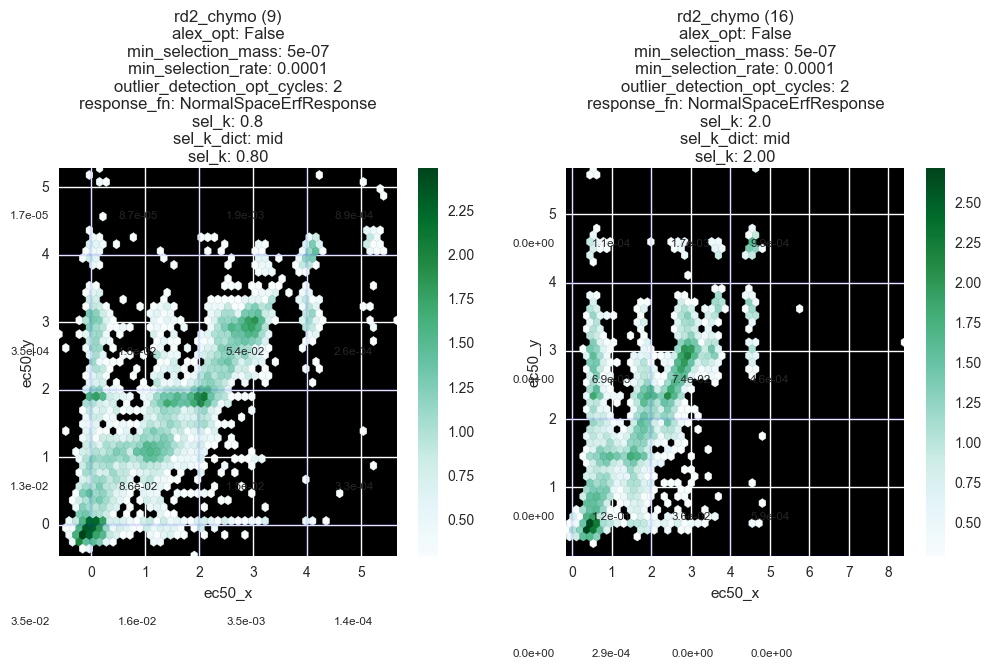

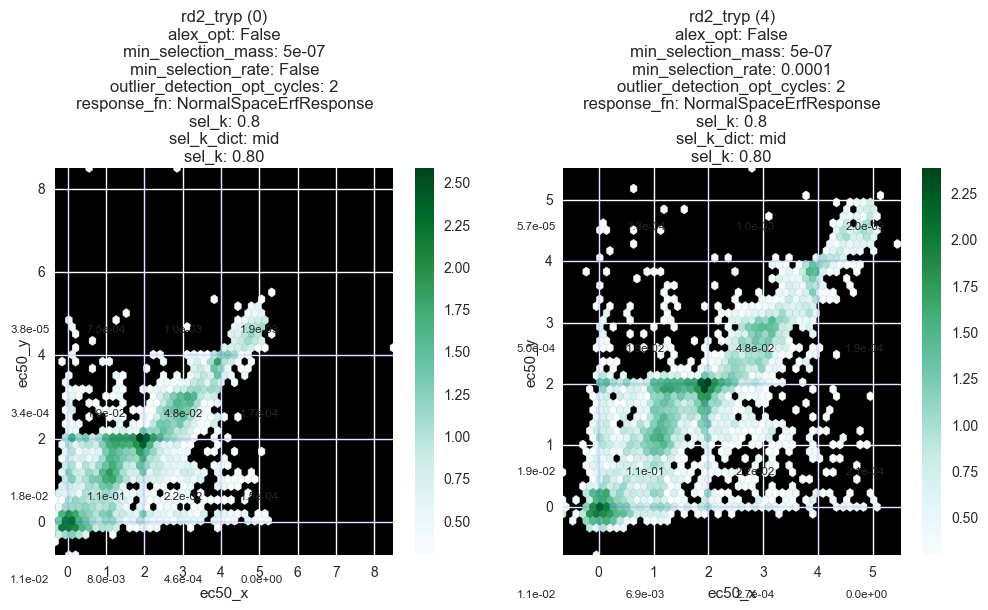

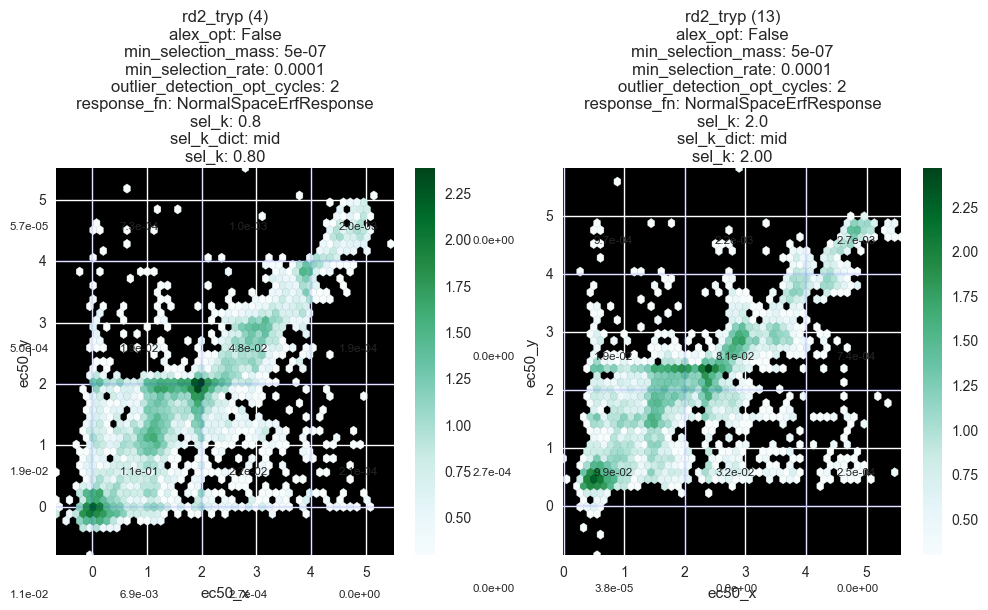

In [47]:
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
plot_eval_pair(ax,9)
ax=plt.subplot(122)
plot_eval_pair(ax,16)

plt.figure(figsize=(12,5))
ax=plt.subplot(121)
plot_eval_pair(ax,0)
ax=plt.subplot(122)
plot_eval_pair(ax,4)

plt.figure(figsize=(12,5))
ax=plt.subplot(121)
plot_eval_pair(ax,4)
ax=plt.subplot(122)
plot_eval_pair(ax,13)

In [52]:
eval_records['model'] = [None for x in range(len(eval_records))]

In [53]:
import protease_experimental_analysis
import protease_experimental_analysis.data as data
import protease_experimental_analysis.protease_sequencing_model as protease_sequencing_model
reload (protease_experimental_analysis)
reload (protease_sequencing_model)

for mr in model_results.keys():
    dataset, parameters = mr
    model_results[mr]['model'] = (
        protease_sequencing_model.FractionalSelectionModel(**dict(parameters))
        .build_model(data.model_input[dataset])
    )
    model_results[mr]['recalc_logp'] = model_results[mr]['model'].logp(model_results[mr]['params'])
    print (dataset, dict(parameters)['response_fn'], model_results[mr]['recalc_logp'], model_results[mr]['predictions']['logp'])

2016-12-17T17:16:19.276 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:19.277 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:19.278 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:19.278 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:19.279 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:19.280 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:16:31.435 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:31.435 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:31.436 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:31.437 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:31.437 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:31.438 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_tryp NormalSpaceErfResponse -228435.667789 -228435.667789
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:16:37.303 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:37.304 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:37.304 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:37.305 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:37.305 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:37.306 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_chymo NormalSpaceErfResponse -952758.324972 -952758.324972
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:16:41.600 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:41.602 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:41.603 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:41.603 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:41.604 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:41.605 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_tryp NormalSpaceErfResponse -295221.012466 -295221.012466
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:16:47.067 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:47.068 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:47.068 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:47.069 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:47.070 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:47.070 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_tryp NormalSpaceErfResponse -292149.77185 -292149.77185
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:16:56.600 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:56.600 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:56.601 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:56.602 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:56.602 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:16:56.603 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_chymo NormalSpaceErfResponse -842654.345884 -842654.345884
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:17:06.262 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:06.263 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:06.263 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:06.264 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:06.265 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:06.265 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_chymo NormalSpaceErfResponse -323976.156223 -323976.156223
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:17:13.619 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:13.620 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:13.620 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:13.621 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:13.622 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:13.622 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_tryp NormalSpaceLogisticResponse -294347.274904 -294347.274904
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:17:24.292 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:24.293 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:24.293 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:24.294 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:24.295 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:24.296 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_chymo NormalSpaceErfResponse -714765.750746 -714765.750746
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:17:34.589 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:34.589 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:34.590 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:34.590 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:34.591 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:34.591 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_chymo NormalSpaceErfResponse -236812.811392 -236812.811392
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:17:46.263 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:46.263 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:46.264 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:46.264 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:46.265 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:46.266 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_redo_tryp NormalSpaceErfResponse -314702.761203 -314702.761203
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:17:57.102 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:57.103 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:57.104 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:57.104 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:57.105 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:17:57.105 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_redo_tryp NormalSpaceErfResponse -368962.085074 -368962.085074
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:18:08.371 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:08.372 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:08.372 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:08.372 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:08.373 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:08.374 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_redo_tryp NormalSpaceErfResponse -288289.522642 -288289.522642
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:18:21.430 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:21.430 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:21.431 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:21.431 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:21.432 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:21.432 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_redo_tryp NormalSpaceErfResponse -370889.402311 -370889.402311
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:18:26.877 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:26.877 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:26.878 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:26.878 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:26.879 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:26.880 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_redo_tryp NormalSpaceErfResponse -371422.900029 -371422.900029
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:18:32.333 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:32.333 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:32.334 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:32.335 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:32.335 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:32.336 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_redo_chymo NormalSpaceErfResponse -334880.613239 -334880.613239
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:18:41.485 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:41.486 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:41.486 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:41.487 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:41.487 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:41.488 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_chymo NormalSpaceErfResponse -547335.285822 -547335.285822
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:18:54.353 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:54.354 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:54.354 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:54.355 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:54.355 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:18:54.356 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_chymo NormalSpaceErfResponse -278476.907064 -278476.907064
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:19:05.673 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:05.674 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:05.674 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:05.674 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:05.675 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:05.676 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_chymo NormalSpaceErfResponse -633217.84464 -633217.84464
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:19:09.918 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:09.919 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:09.919 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:09.920 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:09.920 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:09.921 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_redo_chymo NormalSpaceLogisticResponse -362819.823577 -362819.823577
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:19:15.675 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:15.676 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:15.676 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:15.677 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:15.677 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:15.678 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_chymo NormalSpaceErfResponse -388462.702429 -388462.702429


2016-12-17T17:19:17.503 protease_experimental_analysis.protease_sequencing_model Inferred sel_ec50 range: {'upper': 8.5, 'lower': -1.5}
2016-12-17T17:19:17.625 protease_experimental_analysis.protease_sequencing_model Adding const min_selection_rate: 0.001
2016-12-17T17:19:17.625 protease_experimental_analysis.protease_sequencing_model Adding const min_selection_mass: 0.000


Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:19:21.501 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:21.502 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:21.503 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:21.503 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:21.504 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:21.504 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_tryp NormalSpaceErfResponse -277999.844591 -277999.844591
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:19:35.658 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:35.658 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:35.659 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:35.659 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:35.660 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:35.660 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_redo_tryp NormalSpaceErfResponse -291984.654132 -291984.654132
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:19:45.975 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:45.976 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:45.976 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:45.977 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:45.978 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:45.978 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_tryp NormalSpaceErfResponse -293616.67388 -293616.67388
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:19:56.586 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:56.587 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:56.587 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:56.588 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:56.589 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:19:56.590 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_tryp NormalSpaceErfResponse -284756.418588 -284756.418588
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:20:00.817 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:00.818 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:00.818 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:00.819 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:00.820 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:00.820 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_chymo NormalSpaceLogisticResponse -861029.546148 -861029.546148
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:20:16.427 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:16.428 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:16.428 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:16.429 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:16.430 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:16.430 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_redo_chymo NormalSpaceErfResponse -462121.748777 -462121.748777
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:20:20.260 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:20.261 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:20.261 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:20.262 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:20.262 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:20.263 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_redo_chymo NormalSpaceErfResponse -428661.582748 -428661.582748
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:20:24.218 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:24.218 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:24.219 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:24.219 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:24.220 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:24.221 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_tryp NormalSpaceErfResponse -232737.301241 -232737.301241
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:20:40.635 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:40.636 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:40.636 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:40.637 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:40.638 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:40.638 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_redo_tryp NormalSpaceErfResponse -307461.324479 -307461.324479
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:20:57.691 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:57.692 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:57.692 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:57.693 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:57.694 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:20:57.694 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_chymo NormalSpaceErfResponse -780594.792643 -780594.792643
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:21:09.795 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:09.796 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:09.797 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:09.797 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:09.798 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:09.798 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_tryp NormalSpaceErfResponse -252545.326514 -252545.326514
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:21:13.720 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:13.721 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:13.722 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:13.722 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:13.723 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:13.723 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_redo_chymo NormalSpaceErfResponse -607296.419565 -607296.419565
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:21:25.951 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:25.951 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:25.952 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:25.952 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:25.953 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:25.954 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_tryp NormalSpaceErfResponse -261703.830496 -261703.830496
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:21:29.955 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:29.955 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:29.956 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:29.956 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:29.957 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:29.957 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_redo_tryp NormalSpaceErfResponse -300538.585523 -300538.585523
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:21:48.522 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:48.522 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:48.523 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:48.524 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:48.525 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:21:48.525 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_tryp NormalSpaceErfResponse -273077.565535 -273077.565535
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:22:04.381 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:04.382 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:04.382 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:04.383 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:04.384 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:04.384 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_redo_chymo NormalSpaceErfResponse -182400.649287 -182400.649287
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:22:14.466 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:14.466 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:14.467 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:14.467 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:14.468 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:14.469 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_redo_tryp NormalSpaceLogisticResponse -335840.604061 -335840.604061
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:22:18.760 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:18.761 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:18.761 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:18.762 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:18.763 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:18.763 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_redo_chymo NormalSpaceLogisticResponse -576237.156276 -576237.156276
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:22:32.072 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:32.073 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:32.073 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:32.074 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:32.074 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:32.075 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_tryp NormalSpaceErfResponse -243250.422023 -243250.422023
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:22:52.409 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:52.410 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:52.411 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:52.411 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:52.412 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:52.412 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_chymo NormalSpaceErfResponse -300767.894644 -300767.894644
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:22:56.480 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:56.480 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:56.481 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:56.481 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:56.482 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:22:56.483 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_redo_chymo NormalSpaceErfResponse -243957.529086 -243957.529086
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:23:00.787 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:00.788 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:00.788 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:00.789 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:00.789 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:00.790 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_chymo NormalSpaceLogisticResponse -395642.6394 -395642.6394
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:23:11.675 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:11.675 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:11.676 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:11.677 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:11.677 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:11.678 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_tryp NormalSpaceErfResponse -290115.55439 -290115.55439
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:23:15.657 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:15.657 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:15.658 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:15.659 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:15.659 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:15.660 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_redo_tryp NormalSpaceErfResponse -370117.32125 -370117.32125
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:23:33.090 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:33.091 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:33.091 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:33.092 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:33.093 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:33.093 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_redo_chymo NormalSpaceErfResponse -374158.736535 -374158.736535
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:23:37.291 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:37.291 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:37.292 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:37.292 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:37.293 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:37.294 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_tryp NormalSpaceLogisticResponse -280684.584623 -280684.584623
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:23:58.279 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:58.280 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:58.280 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:58.281 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:58.281 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:23:58.282 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_redo_chymo NormalSpaceErfResponse -420501.917913 -420501.917913
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:24:02.679 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:02.679 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:02.680 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:02.680 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:02.681 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:02.682 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_redo_tryp NormalSpaceLogisticResponse -376125.468387 -376125.468387
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:24:21.004 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:21.004 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:21.005 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:21.006 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:21.006 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:21.007 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_redo_chymo NormalSpaceErfResponse -273522.126194 -273522.126194
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:24:44.264 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:44.265 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:44.265 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:44.266 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:44.266 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:44.267 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_redo_chymo NormalSpaceErfResponse -210948.712111 -210948.712111
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:24:48.588 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:48.589 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:48.589 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:48.590 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:48.591 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:48.592 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_redo_chymo NormalSpaceErfResponse -506551.683915 -506551.683915
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:24:52.675 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:52.675 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:52.676 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:52.677 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:52.677 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:24:52.678 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_chymo NormalSpaceErfResponse -254560.628904 -254560.628904
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:25:13.557 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:25:13.557 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:25:13.558 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:25:13.559 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:25:13.559 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:25:13.560 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_redo_chymo NormalSpaceErfResponse -307455.744309 -307455.744309
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:25:19.553 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:25:19.553 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:25:19.554 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:25:19.555 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:25:19.555 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:25:19.556 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd2_redo_tryp NormalSpaceErfResponse -338150.46771 -338150.46771
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


2016-12-17T17:25:44.708 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[0] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:25:44.709 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[1] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:25:44.710 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[2] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:25:44.710 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[3] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:25:44.711 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[4] : set(['name', 'seq_counts', 'num_selected', 'min_fraction'])
2016-12-17T17:25:44.712 protease_experimental_analysis.protease_sequencing_model Unused keys in population_data[5] 

rd3_redo_tryp NormalSpaceErfResponse -367604.352316 -367604.352316
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.
rd3_redo_tryp NormalSpaceErfResponse -368646.06306 -368646.06306


In [ ]:
#model_results[mr]['recalc_logp'] = model_results[mr]['model'].logp(model_results[mr]['params'])

In [54]:
import copy

In [55]:
import protease_experimental_analysis
import protease_experimental_analysis.data as data
import protease_experimental_analysis.protease_sequencing_model as protease_sequencing_model

model_table=[]

for mr in model_results.keys():
    dataset, parameters = mr
    try:
        print (dataset, dict(parameters)['response_fn'], model_results[mr]['recalc_logp'], model_results[mr]['predictions']['logp'])
        model_table.append([dataset, parameters, dict(parameters)['response_fn'],dict(parameters)['sel_k_dict'],
                            model_results[mr]['model'], model_results[mr], model_results[mr]['recalc_logp'], model_results[mr]['predictions']['logp']])
    except:
        print (dataset, parameters)
    #model_table['fraction_selected'] = 
    
    
model_table = pd.DataFrame(model_table)
model_table.columns = ['dataset','params','response_fn','sel_k_dict','model','predictions','new_logp','old_logp']

rd2_tryp NormalSpaceErfResponse -228435.667789 -228435.667789
rd2_chymo NormalSpaceErfResponse -952758.324972 -952758.324972
rd3_tryp NormalSpaceErfResponse -295221.012466 -295221.012466
rd2_tryp NormalSpaceErfResponse -292149.77185 -292149.77185
rd2_chymo NormalSpaceErfResponse -842654.345884 -842654.345884
rd3_chymo NormalSpaceErfResponse -323976.156223 -323976.156223
rd3_tryp NormalSpaceLogisticResponse -294347.274904 -294347.274904
rd2_chymo NormalSpaceErfResponse -714765.750746 -714765.750746
rd3_chymo NormalSpaceErfResponse -236812.811392 -236812.811392
rd2_redo_tryp NormalSpaceErfResponse -314702.761203 -314702.761203
rd3_redo_tryp NormalSpaceErfResponse -368962.085074 -368962.085074
rd2_redo_tryp NormalSpaceErfResponse -288289.522642 -288289.522642
rd3_redo_tryp NormalSpaceErfResponse -370889.402311 -370889.402311
rd3_redo_tryp NormalSpaceErfResponse -371422.900029 -371422.900029
rd3_redo_chymo NormalSpaceErfResponse -334880.613239 -334880.613239
rd2_chymo NormalSpaceErfRespons

In [56]:
len(model_results)

56

In [57]:
model_table.model.values[0].model_populations[4]['fraction_selected'](model_table.ix[0, 'predictions']['params'])

array(0.10166661120937176)

In [58]:
from sklearn.metrics import mean_squared_error

In [59]:
model_table['data_fraction_selected'] = [range(3) for x in range(len(model_table))]
model_table['fit_fraction_selected'] = [range(3) for x in range(len(model_table))]
for i in model_table.index:
    dataset, params = model_table.ix[i, 'dataset'], model_table.ix[i, 'params']
    log_model = model_table.ix[(model_table['dataset'] == dataset) & (model_table['response_fn'] == 'NormalSpaceLogisticResponse'), 'model'].values[0]
    erf_model = model_table.ix[(model_table['dataset'] == dataset) & (model_table['response_fn'] == 'NormalSpaceErfResponse'), 'model'].values[0]
    fit_params = model_table.ix[i, 'predictions']['params']
    my_model = model_table.ix[i, 'model']
    
    #model_table.ix[i, 'log logp'] = log_model.logp(fit_params)
    #model_table.ix[i, 'erf logp'] = erf_model.logp(fit_params)
    
    data_fraction_selected= np.array([my_model.population_data[k]['fraction_selected'] for k in range(3,7)])
    fit_fraction_selected= np.array([my_model.model_populations[k]['fraction_selected'](fit_params) for k in range(3,7)])
    #print (dataset, data_fraction_selected, fit_fraction_selected)
    if dataset in ['rd3_tryp','rd3_redo_tryp']:
        data_fraction_selected = data_fraction_selected[1:]
        fit_fraction_selected = fit_fraction_selected[1:]
    
    model_table.ix[i, 'fraction_selected_rmse'] = mean_squared_error(data_fraction_selected,
                                                                   fit_fraction_selected)**0.5
    model_table.set_value(i, 'data_fraction_selected', data_fraction_selected)
    model_table.set_value(i, 'fit_fraction_selected', fit_fraction_selected)
    model_table.set_value(i, 'min_selection_rate', dict(model_table.ix[i,'params'])['min_selection_rate'])
    
    
model_table.sort(['dataset','response_fn','min_selection_rate'])
    

,dataset,params,response_fn,sel_k_dict,model,predictions,new_logp,old_logp,data_fraction_selected,fit_fraction_selected,fraction_selected_rmse,min_selection_rate
1,rd2_chymo,"((response_fn, NormalSpaceErfResponse), (outli...",NormalSpaceErfResponse,mid,<protease_experimental_analysis.protease_seque...,"{u'recalc_logp': -952758.324972, u'logp': -952...",-952758.324972,-952758.324972,"[0.282684563758, 0.0266263982103, 0.0348822652...","[0.282062971859, 0.0681535028746, 0.1359711991...",0.055384,0.00000
4,rd2_chymo,"((outlier_detection_opt_cycles, 2), (min_selec...",NormalSpaceErfResponse,mid,<protease_experimental_analysis.protease_seque...,"{u'recalc_logp': -842654.345884, u'logp': -842...",-842654.345884,-842654.345884,"[0.282684563758, 0.0266263982103, 0.0348822652...","[0.281635557434, 0.0663672453037, 0.0968762732...",0.039806,0.00003
29,rd2_chymo,"((response_fn, NormalSpaceErfResponse), (outli...",NormalSpaceErfResponse,mid,<protease_experimental_analysis.protease_seque...,"{u'recalc_logp': -780594.792643, u'logp': -780...",-780594.792643,-780594.792643,"[0.282684563758, 0.0266263982103, 0.0348822652...","[0.280277467897, 0.0629943075639, 0.0825857169...",0.033758,0.00010
7,rd2_chymo,"((response_fn, NormalSpaceErfResponse), (outli...",NormalSpaceErfResponse,mid,<protease_experimental_analysis.protease_seque...,"{u'recalc_logp': -714765.750746, u'logp': -714...",-714765.750746,-714765.750746,"[0.282684563758, 0.0266263982103, 0.0348822652...","[0.278307199322, 0.0596440463996, 0.0747049012...",0.030302,0.00030
17,rd2_chymo,"((response_fn, NormalSpaceErfResponse), (min_s...",NormalSpaceErfResponse,mid,<protease_experimental_analysis.protease_seque...,"{u'recalc_logp': -633217.84464, u'logp': -6332...",-633217.84464,-633217.84464,"[0.282684563758, 0.0266263982103, 0.0348822652...","[0.274495558817, 0.0533719341179, 0.0550918160...",0.023705,0.00100
15,rd2_chymo,"((response_fn, NormalSpaceErfResponse), (min_s...",NormalSpaceErfResponse,mid,<protease_experimental_analysis.protease_seque...,"{u'recalc_logp': -547335.285822, u'logp': -547...",-547335.285822,-547335.285822,"[0.282684563758, 0.0266263982103, 0.0348822652...","[0.270976938559, 0.0500679960392, 0.0473683809...",0.021500,0.00300
24,rd2_chymo,"((response_fn, NormalSpaceLogisticResponse), (...",NormalSpaceLogisticResponse,mid,<protease_experimental_analysis.protease_seque...,"{u'recalc_logp': -861029.546148, u'logp': -861...",-861029.546148,-861029.546148,"[0.282684563758, 0.0266263982103, 0.0348822652...","[0.282825352328, 0.0732074019778, 0.1286939301...",0.054383,0.00000
26,rd2_redo_chymo,"((response_fn, NormalSpaceErfResponse), (outli...",NormalSpaceErfResponse,mid,<protease_experimental_analysis.protease_seque...,"{u'recalc_logp': -428661.582748, u'logp': -428...",-428661.582748,-428661.582748,"[0.273910683012, 0.0184343257443, 0.0183786816...","[0.262143944104, 0.0518003663819, 0.0378146527...",0.020242,0.00000
52,rd2_redo_chymo,"((outlier_detection_opt_cycles, 2), (min_selec...",NormalSpaceErfResponse,mid,<protease_experimental_analysis.protease_seque...,"{u'recalc_logp': -307455.744309, u'logp': -307...",-307455.744309,-307455.744309,"[0.273910683012, 0.0184343257443, 0.0183786816...","[0.261343525866, 0.0492818308625, 0.0185839604...",0.017003,0.00003
48,rd2_redo_chymo,"((response_fn, NormalSpaceErfResponse), (outli...",NormalSpaceErfResponse,mid,<protease_experimental_analysis.protease_seque...,"{u'recalc_logp': -273522.126194, u'logp': -273...",-273522.126194,-273522.126194,"[0.273910683012, 0.0184343257443, 0.0183786816...","[0.2616195538, 0.0484308646823, 0.016877659867...",0.016577,0.00010


In [60]:
def scatter_i1_i2(i1, i2):
    dataset = eval_records.ix[idx]["dataset"]
    params = eval_records.ix[idx]["param_set"]


    title = ["%s (%i)" % (dataset, idx)]
    
    if params != "grocklin":
        sf = replicate_summary_frames[(dataset, params)]

        fit_params = model_results[(dataset, params)]["params"]
        params = dict(params)
        for k in sorted(params):
            if k in fit_params:
                p = numpy.atleast_1d(fit_params[k])
                title.append("%s: %s (%s)" % (k, params[k], ",".join("%.1e" % f for f in p)))
            else:
                title.append("%s: %s" % (k, params[k]))
        title.append("sel_k: %.2f" % fit_params["sel_k"])
    else:
        title.append("grocklin")
        sf = grocklin_replicate_summary_frames[(dataset, "grocklin")]
        
    ax.set_title("\n".join(title))

In [61]:
model_table.ix[4]['params']

frozenset({('alex_opt', False),
           ('min_selection_mass', 5e-07),
           ('min_selection_rate', 3e-05),
           ('outlier_detection_opt_cycles', 2),
           ('response_fn', 'NormalSpaceErfResponse'),
           ('sel_k_dict', 'mid')})

/Users/grocklin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/grocklin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/grocklin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/grocklin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


1 26
4 52
29 48
7 40
17 49
15 35


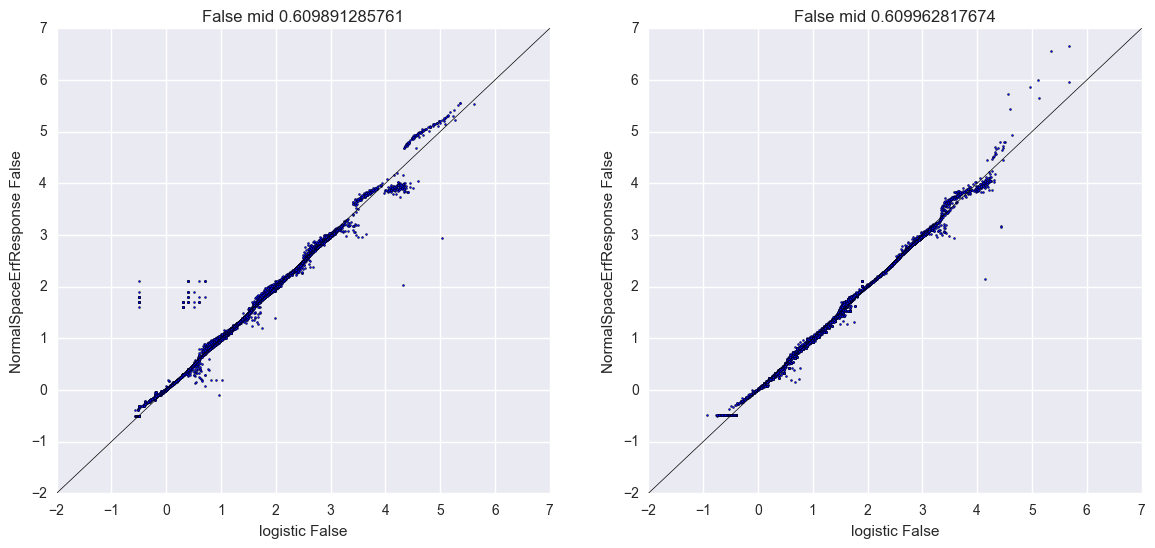

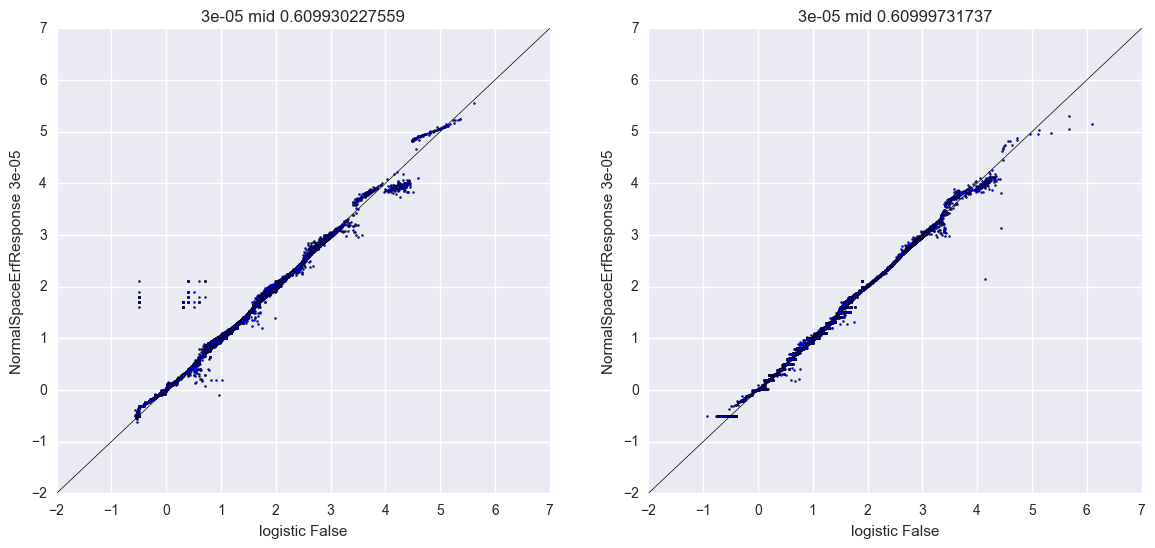

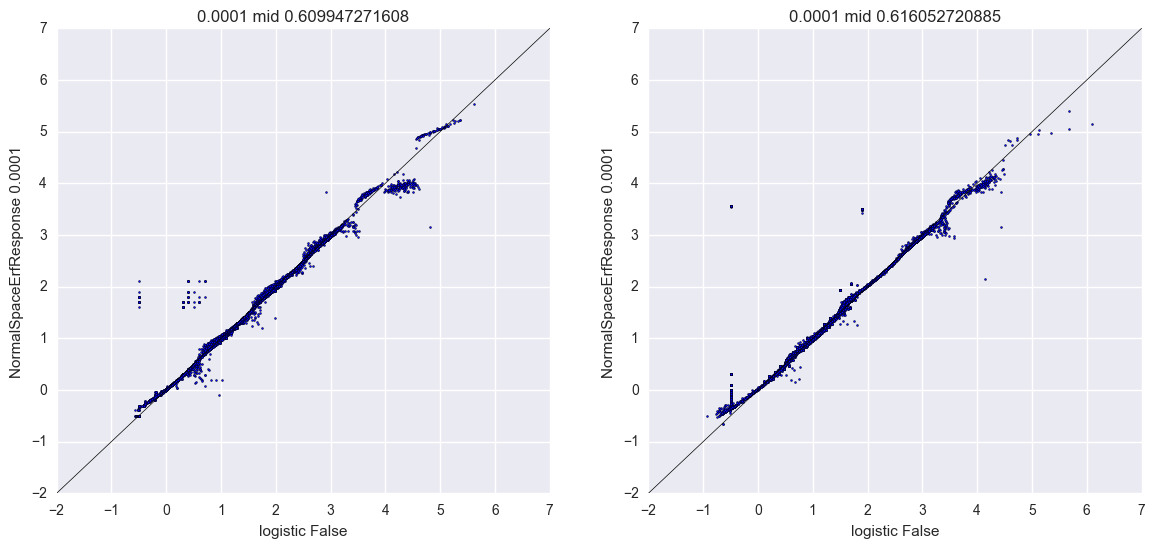

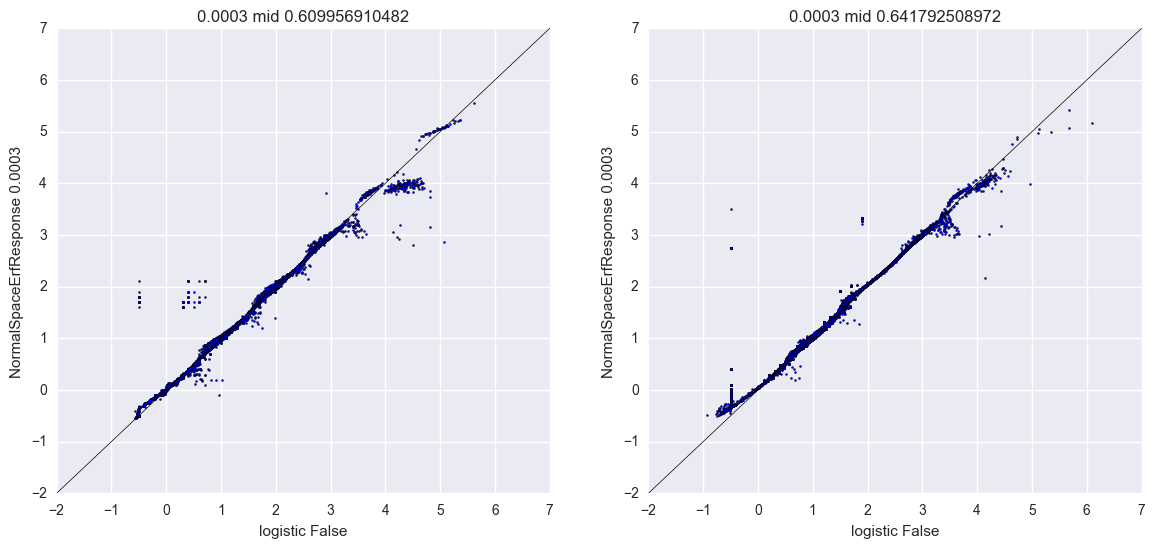

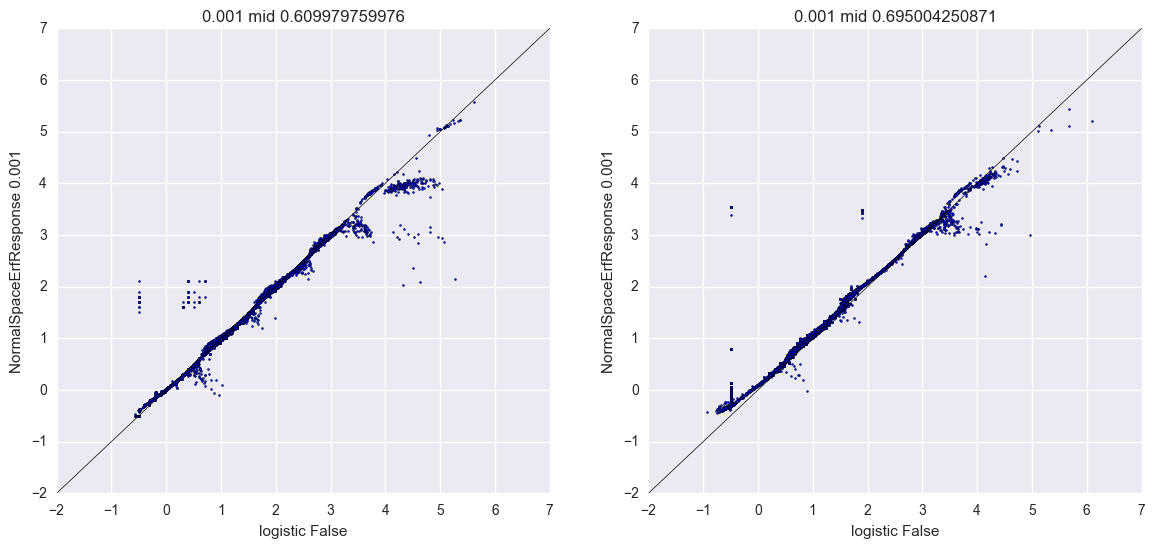

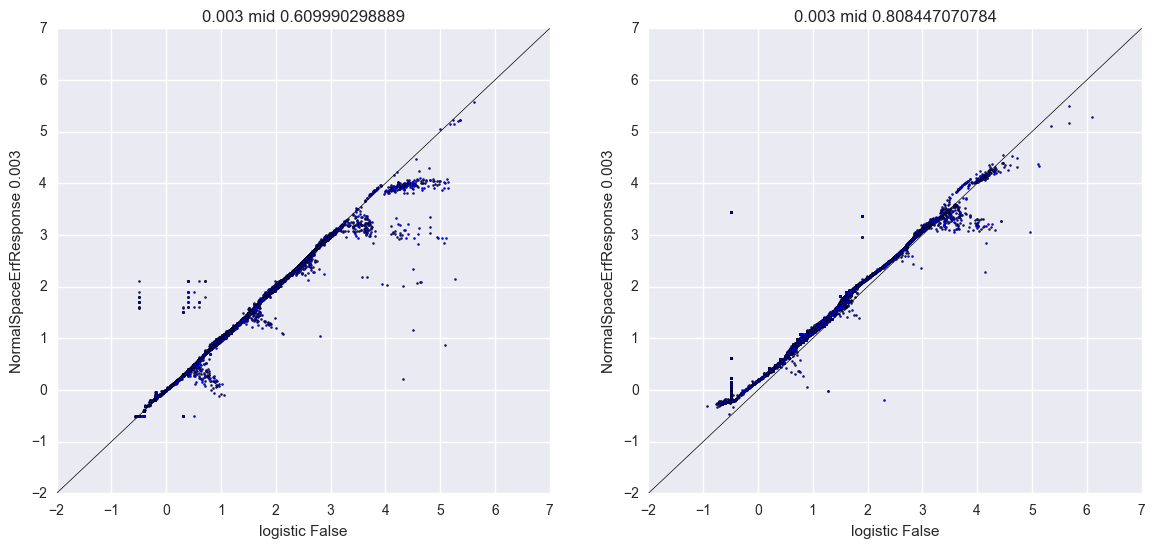

In [62]:
#msm_lookup = {str(m) : m for m in list(set(eval_records["min_selection_rate"]))}
c1_lookup = {str(m) : m for m in list(set(model_table["dataset"]))}
c2_lookup = {str(m) : m for m in list(set(model_table["response_fn"]))}


@ipyw.interact
def display_records_by_param(
    c1 = c1_lookup.keys(),
    c2 = c2_lookup.keys()
    #c3 = msm_lookup.keys(),
):
    
    c1 = c1_lookup[c1]
    c2 = c2_lookup[c2]
    #c3 = msm_lookup[c3]
    
    default1=model_table[model_table["dataset"] == c1][model_table["min_selection_rate"] == False][model_table["response_fn"] == 'NormalSpaceLogisticResponse'].index.values[0]
    default2=model_table[model_table["dataset"] == c1.replace('_tryp','_redo_tryp').replace('_chymo','_redo_chymo')][model_table["min_selection_rate"] == False][model_table["response_fn"] == 'NormalSpaceLogisticResponse'].index.values[0]
    
    
    r1 = model_table[model_table["dataset"] == c1][model_table["response_fn"] == c2].sort_values(["min_selection_rate","sel_k_dict"])
    r2 = model_table[model_table["dataset"] == c1.replace('_tryp','_redo_tryp').replace('_chymo','_redo_chymo')][model_table["response_fn"] == c2].sort_values(["min_selection_rate","sel_k_dict"])
    
    for i1, i2 in zip(r1.index, r2.index):
        print (i1,i2)
    
        plt.figure(figsize=(14,6))
        plt.subplot(121)
        plt.scatter(model_table.ix[default1]['predictions']['params']['sel_ec50'], model_table.ix[i1]['predictions']['params']['sel_ec50'],2)
        plt.title('%s %s %s' % (dict(model_table.ix[i1]['params'])['min_selection_rate'],
                            dict(model_table.ix[i1]['params'])['sel_k_dict'],
                            model_table.ix[i1]['predictions']['params']['sel_k']))
        plt.xlabel('logistic False')
        plt.ylabel('%s %s' % (c2, dict(model_table.ix[i1]['params'])['min_selection_rate']))
        plt.xlim(-2,7)
        plt.ylim(-2,7)
        
        plt.plot([-2,7],[-2,7],linewidth=0.5,color='black')
        plt.subplot(122)
        plt.scatter(model_table.ix[default2]['predictions']['params']['sel_ec50'], model_table.ix[i2]['predictions']['params']['sel_ec50'],2)
        plt.title('%s %s %s' % (dict(model_table.ix[i2]['params'])['min_selection_rate'],
                            dict(model_table.ix[i2]['params'])['sel_k_dict'],
                               model_table.ix[i2]['predictions']['params']['sel_k']))
        plt.xlabel('logistic False')
        plt.ylabel('%s %s' % (c2, dict(model_table.ix[i2]['params'])['min_selection_rate']))
        plt.plot([-2,7],[-2,7],linewidth=0.5,color='black')
        plt.xlim(-2,7)
        plt.ylim(-2,7)
    #plt.tight_layout()

In [ ]:
model_table.ix[2]['predictions']

In [ ]:
#msm_lookup = {str(m) : m for m in list(set(eval_records["min_selection_rate"]))}
c1_lookup = {str(m) : m for m in list(set(model_table["dataset"]))}
c2_lookup = {str(m) : m for m in list(set(model_table["response_fn"]))}


@ipyw.interact
def display_records_by_param(
    c1 = c1_lookup.keys(),
    c2 = c2_lookup.keys()
    #c3 = msm_lookup.keys(),
):
    
    c1 = c1_lookup[c1]
    c2 = c2_lookup[c2]
    #c3 = msm_lookup[c3]
    
    default1=model_table[model_table["dataset"] == c1][model_table["min_selection_rate"] == False][model_table["response_fn"] == 'NormalSpaceLogisticResponse'].index.values[0]
    default2=model_table[model_table["dataset"] == c1.replace('_tryp','_redo_tryp').replace('_chymo','_redo_chymo')][model_table["min_selection_rate"] == False][model_table["response_fn"] == 'NormalSpaceLogisticResponse'].index.values[0]
    
    
    r1 = model_table[model_table["dataset"] == c1][model_table["response_fn"] == c2].sort_values(["min_selection_rate","sel_k_dict"])
    r2 = model_table[model_table["dataset"] == c1.replace('_tryp','_redo_tryp').replace('_chymo','_redo_chymo')][model_table["response_fn"] == c2].sort_values(["min_selection_rate","sel_k_dict"])
    
    for i1, i2 in zip(r1.index, r2.index):
        print (i1,i2)
    
        plt.figure(figsize=(14,6))
        plt.subplot(121)
        #plt.scatter(model_table.ix[default1]['predictions']['params']['sel_ec50'], model_table.ix[i1]['predictions']['params']['sel_ec50'],2)
        plt.hist(model_table.ix[default1]['predictions']['params']['sel_ec50'][model_table.ix[default1]['predictions']['ec50_95ci'] < 2]   ,bins=np.arange(-1,6,0.1),color='darkgrey', alpha=1,histtype='step',linewidth=3)
        plt.hist(model_table.ix[i1]['predictions']['params']['sel_ec50'][model_table.ix[i1]['predictions']['ec50_95ci'] < 2],bins=np.arange(-1,6,0.1),color='red', alpha=1,histtype='step',linewidth=3)
        
        
        plt.title('%s %s' % (dict(model_table.ix[i1]['params'])['min_selection_rate'],
                            dict(model_table.ix[i1]['params'])['sel_k_dict']))
        plt.xlabel('logistic False')
        plt.ylabel('%s %s' % (c2, dict(model_table.ix[i1]['params'])['min_selection_rate']))
        plt.xlim(-1,6)
        plt.ylim(0,700)
        
        plt.plot([-2,7],[-2,7],linewidth=0.5,color='black')
        plt.subplot(122)
        #plt.scatter(model_table.ix[default2]['predictions']['params']['sel_ec50'], model_table.ix[i2]['predictions']['params']['sel_ec50'],2)
        plt.hist(model_table.ix[default2]['predictions']['params']['sel_ec50'][model_table.ix[default2]['predictions']['ec50_95ci'] < 2],bins=np.arange(-1,6,0.1),color='darkgrey', alpha=1,histtype='step',linewidth=3)
        plt.hist(model_table.ix[i2]['predictions']['params']['sel_ec50'][model_table.ix[i2]['predictions']['ec50_95ci'] < 2],bins=np.arange(-1,6,0.1),color='red', alpha=1,histtype='step',linewidth=3)
        plt.title('%s %s' % (dict(model_table.ix[i2]['params'])['min_selection_rate'],
                            dict(model_table.ix[i2]['params'])['sel_k_dict']))
        plt.xlabel('logistic False')
        plt.ylabel('%s %s' % (c2, dict(model_table.ix[i2]['params'])['min_selection_rate']))
        plt.plot([-2,7],[-2,7],linewidth=0.5,color='black')
        plt.xlim(-1,6)
        plt.ylim(0,700)
    #plt.tight_layout()

In [ ]:
model_table[model_table['dataset'] == 'rd2_tryp']

In [ ]:
model_table[['dataset',
             'response_fn','fraction_selected_mse',
             'old_logp',
             'log logp',
             'erf logp']].sort(['dataset','response_fn'])

In [ ]:
display(model_table.ix[(model_table.dataset=='rd3_chymo')]['data_fraction_selected'])
display(model_table.ix[(model_table.dataset=='rd3_chymo')]['fit_fraction_selected'].values[0])
display(model_table.ix[(model_table.dataset=='rd3_chymo')]['fit_fraction_selected'].values[1])


In [ ]:
display(model_table.ix[(model_table.dataset=='rd3_chymo')]['response_fn'].values[0])
display(model_table.ix[(model_table.dataset=='rd3_chymo')]['response_fn'].values[1])

In [ ]:
model_table.ix[13,'params']

In [ ]:
model_table.ix[39,'params']

In [ ]:
plt.scatter(model_table.ix[50,'predictions']['params']['sel_ec50'],
            model_table.ix[69,'predictions']['params']['sel_ec50'])
plt.figure()
plt.scatter(model_table.ix[50,'predictions']['params']['sel_ec50'],
            model_table.ix[69,'predictions']['params']['sel_ec50'])
plt.xlim(3.5,5.5)
plt.ylim(3.5,5.5)
plt.plot([0,6],[0,6])

In [ ]:
from scipy.special import expit, erf
import scipy.stats
from matplotlib import pylab

In [64]:
def plot_fit_summary(model, i, fit):


        sel_sum = model.model_selection_summary(fit)
        
        sel_levels = {
            k : p["selection_level"] if p["selection_level"] else 0
            for k, p in model.population_data.items()}
        
        sel_fracs = {
            k : p["selected"][i] / p["selected"].sum()
            for k, p in model.population_data.items()}
        
        pylab.xticks(
            sel_levels.values(), sel_levels.keys())
        pylab.xlim((-1, 7))
        
        porder = [
            k for k, p in
            sorted(model.population_data.items(), key=lambda (k, p): p["selection_level"])]
        
        pylab.plot(
            [sel_levels[k] for k in porder],
            [sel_fracs[k] for k in porder],
            "-o",
            color="black", label="observed")
        
        lbl = False
        for k in sel_sum:
            n = sel_sum[k]["selected"].sum()
            p = sel_sum[k]["pop_fraction"][i]
            sel_level = model.population_data[k]["selection_level"]
            counts=sel_sum[k]["selected"][i]
            plt.text(sel_levels[k] + 0.2, sel_fracs[k], '%.0f' % counts)
            
            if p<=0:
                continue
            
            bn = scipy.stats.binom(n=n, p=p)
            
            parkey = model.population_data[k]["parent"]
            pylab.plot(
                [sel_levels[parkey], sel_levels[k]],
                [sel_fracs[parkey], float(bn.ppf(.5)) / n],
                "--", color="red", alpha=.25
            )
            
            
            
            
            for ci in (.68, .95, .99):
                pylab.plot(
                    [sel_level] * 2, bn.ppf([ci, 1-ci]) / n,
                    linewidth=10, color="red", alpha=.25,
                    label="predicted" if not lbl else None
                )
                lbl=True
                
        pylab.legend(fontsize="large", loc="best")
        
        pylab.twinx()
        xs = numpy.linspace(-2, 8)
        sel_ec50 = fit["sel_ec50"][i]
        sel_k = fit["sel_k"]
        x_integers=np.arange(0,7)
        
        
        sel_xs = sel_k * (3.0 ** (xs - sel_ec50) - 1.0)
        sel_x_integers=sel_k * (3.0 ** (x_integers - sel_ec50) - 1.0)

        pylab.plot(xs, scipy.special.expit(-sel_xs*2.45), alpha=.75)
        pylab.plot(xs, (scipy.special.erf(-sel_xs) + 1.0)/2.0, alpha=.75)
        
        expits = scipy.special.expit(-sel_x_integers*2.45)
        erfs = (scipy.special.erf(-sel_x_integers) + 1.0)/2.0
        for j in range(3,7):
            print (expits[j], erfs[j])
        
        pylab.yticks([], [])
        
        pylab.title("%s - ec50: %.2f - k: %.2f" % (i, sel_ec50, sel_k))
        print()

In [ ]:
model_table.ix[75]

In [ ]:
model_table.ix[69]

In [ ]:
model_table.ix[(model_table.dataset=='rd2_redo_chymo') & (model_table.sel_k_dict == 'mid') & (model_table.min_selection_rate == 0)]

In [ ]:
data.model_input['rd2_redo_chymo'][0]['name'][data.model_input['rd2_redo_chymo'][0]['name'] == 'HHH_rd2_0096.pdb'].index[0]

In [65]:
#@ipywidgets.interact(i=ipywidgets.IntSlider(max=len(model_table.ix[74,'predictions']['params']['sel_ec50']) - 1))
#quicktable[46]
@ipywidgets.interact(i=ipywidgets.IntSlider(max=len(weirdos)-1))
def pf(i):
    #real_i = np.argsort(model_table.ix[74,'predictions']['params']['sel_ec50'])[ len(model_table.ix[74,'predictions']['params']['sel_ec50'])- i-1]
    real_i=weirdos[i]
    plt.figure(figsize=(10,4))
    plt.subplot(121)

    plot_fit_summary(model_table.ix[50,'model'], real_i, model_table.ix[50,'predictions']['params'])
    plt.subplot(122)
    plot_fit_summary(model_table.ix[69,'model'], real_i, model_table.ix[69,'predictions']['params'])
    
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    
    
    myname = data.model_input['rd2_chymo'][0]['name'][real_i]
    redo_i = data.model_input['rd2_redo_chymo'][0]['name'][data.model_input['rd2_redo_chymo'][0]['name'] == myname].index[0]
    redo_name = data.model_input['rd2_redo_chymo'][0]['name'][redo_i]
    plot_fit_summary(model_table.ix[121,'model'], redo_i, model_table.ix[121,'predictions']['params'])
    plt.subplot(122)
    plot_fit_summary(model_table.ix[76,'model'], redo_i, model_table.ix[76,'predictions']['params'])
    print (myname, redo_name)

NameError: name 'weirdos' is not defined

In [ ]:
ec50_range=np.arange(0,6,0.01)

In [ ]:
i1, i2=69,50
ec_i = 1371
plt.plot(ec50_range,model_table.ix[i1,'predictions']['model'].ec50_logp_trace(model_table.ix[i1,'predictions']['params'], ec_i, ec50_range,include_global_terms=False))
plt.plot(ec50_range,model_table.ix[i1,'predictions']['model'].ec50_logp_trace(model_table.ix[i1,'predictions']['params'], ec_i, ec50_range))
plt.figure()
plt.plot(ec50_range,model_table.ix[i2,'predictions']['model'].ec50_logp_trace(model_table.ix[i2,'predictions']['params'], ec_i, ec50_range,include_global_terms=False))
plt.plot(ec50_range,model_table.ix[i2,'predictions']['model'].ec50_logp_trace(model_table.ix[i2,'predictions']['params'], ec_i, ec50_range))

In [ ]:
ec50_

In [ ]:
ec1 = model_table.ix[50,'predictions']['params']['sel_ec50']
ec2 = model_table.ix[69,'predictions']['params']['sel_ec50']

In [ ]:
weirdos = np.arange(0,len(ec1))[(ec2 < 4.1) & (ec1 > 4.2)]

In [ ]:
weirdos

In [ ]:
model_table.ix[39,'predictions']['predictions'][5]['selection_dist']

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(np.log10((model_table.ix[13]['model'].population_data[5]['selected']+1)/sum(model_table.ix[13]['model'].population_data[5]['selected'])),
            np.log10(model_table.ix[13,'predictions']['predictions'][5]['selection_dist']))
plt.subplot(122)
plt.scatter(np.log10((model_table.ix[39]['model'].population_data[5]['selected']+1)/sum(model_table.ix[39]['model'].population_data[5]['selected'])),
            np.log10(model_table.ix[39,'predictions']['predictions'][5]['selection_dist']))
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(np.log10((model_table.ix[13]['model'].population_data[6]['selected']+1)/sum(model_table.ix[13]['model'].population_data[6]['selected'])),
            np.log10(model_table.ix[13,'predictions']['predictions'][6]['selection_dist']))
plt.subplot(122)
plt.scatter(np.log10((model_table.ix[39]['model'].population_data[6]['selected']+1)/sum(model_table.ix[39]['model'].population_data[6]['selected'])),
            np.log10(model_table.ix[39,'predictions']['predictions'][6]['selection_dist']))


In [ ]:
model_table.ix[74]

In [ ]:
model_table.ix[75]

In [ ]:
model_table.ix[74]['predictions']['params']['sel_k'], model_table.ix[75]['predictions']['params']['sel_k']

KeyError: 74

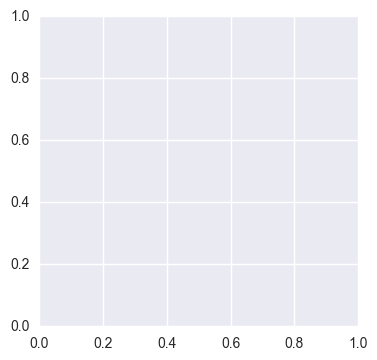

In [66]:
for j in range(1,7):
    plt.figure(figsize=(14,4))
    plt.subplot(131)
    plt.scatter(np.log10((model_table.ix[74]['model'].population_data[j]['selected']+1)/sum(model_table.ix[74]['model'].population_data[j]['selected'])),
                np.log10(model_table.ix[74,'predictions']['predictions'][j]['selection_dist']))
    plt.xlabel('data')
    plt.ylabel('model')
    plt.plot([-6,-1],[-6,-1])
    plt.subplot(132)
    plt.scatter(np.log10((model_table.ix[75]['model'].population_data[j]['selected']+1)/sum(model_table.ix[75]['model'].population_data[j]['selected'])),
                np.log10(model_table.ix[75,'predictions']['predictions'][j]['selection_dist']))
    plt.plot([-6,-1],[-6,-1])
    plt.subplot(133)
    plt.scatter(np.log10(model_table.ix[74,'predictions']['predictions'][j]['selection_dist']),
                np.log10(model_table.ix[75,'predictions']['predictions'][j]['selection_dist']))
    plt.plot([-6,-1],[-6,-1])
    plt.suptitle(j)

In [ ]:
for j in range(1,7):
    plt.figure(figsize=(14,4))
    plt.subplot(131)
    plt.scatter(np.log10((model_table.ix[78]['model'].population_data[j]['selected']+1)/sum(model_table.ix[78]['model'].population_data[j]['selected'])),
                np.log10(model_table.ix[78,'predictions']['predictions'][j]['selection_dist']))
    plt.xlabel('data')
    plt.ylabel('model')
    plt.plot([-6,-1],[-6,-1])
    plt.subplot(132)
    plt.scatter(np.log10((model_table.ix[72]['model'].population_data[j]['selected']+1)/sum(model_table.ix[72]['model'].population_data[j]['selected'])),
                np.log10(model_table.ix[72,'predictions']['predictions'][j]['selection_dist']))
    plt.plot([-6,-1],[-6,-1])
    plt.subplot(133)
    plt.scatter(np.log10(model_table.ix[78,'predictions']['predictions'][j]['selection_dist']),
                np.log10(model_table.ix[72,'predictions']['predictions'][j]['selection_dist']))
    plt.plot([-6,-1],[-6,-1])
    plt.suptitle(j)

In [ ]:
eval_records[(eval_records.dataset=='rd2_chymo') & (eval_records.sel_k_dict == 'mid')].sort_values(['response_fn','min_selection_rate'])

In [ ]:
model_table[(model_table.dataset=='rd2_chymo') & (model_table.sel_k_dict == 'mid')].sort_values(['response_fn','min_selection_rate'])

In [ ]:
i1, i2 = 50,69

for j in range(1,7):
    plt.figure(figsize=(14,4))
    plt.subplot(131)
    plt.scatter(np.log10((model_table.ix[i1]['model'].population_data[j]['selected']+1)/sum(model_table.ix[i1]['model'].population_data[j]['selected'])),
                np.log10(model_table.ix[i1,'predictions']['predictions'][j]['selection_dist']))
    plt.title('RMSE %.4f' % mean_squared_error(np.log10((model_table.ix[i1]['model'].population_data[j]['selected']+1)/sum(model_table.ix[i1]['model'].population_data[j]['selected'])),
                np.log10(model_table.ix[i1,'predictions']['predictions'][j]['selection_dist']))**0.5)
    plt.xlabel('data')
    plt.ylabel('model')
    plt.plot([-6,-1],[-6,-1])
    plt.subplot(132)
    plt.scatter(np.log10((model_table.ix[i2]['model'].population_data[j]['selected']+1)/sum(model_table.ix[i2]['model'].population_data[j]['selected'])),
                np.log10(model_table.ix[i2,'predictions']['predictions'][j]['selection_dist']))
    plt.title('RMSE %.4f' % mean_squared_error(np.log10((model_table.ix[i2]['model'].population_data[j]['selected']+1)/sum(model_table.ix[i2]['model'].population_data[j]['selected'])),
                np.log10(model_table.ix[i2,'predictions']['predictions'][j]['selection_dist']))**0.5)
    
    plt.plot([-6,-1],[-6,-1])
    plt.subplot(133)
    plt.scatter(np.log10(model_table.ix[i1,'predictions']['predictions'][j]['selection_dist']),
                np.log10(model_table.ix[i2,'predictions']['predictions'][j]['selection_dist']))
    plt.plot([-6,-1],[-6,-1])
    plt.xlabel('model/no min rate')
    plt.ylabel('model/with min rate')
    plt.suptitle(j)

In [ ]:
plt.scatter(model_table.ix[13,'predictions']['params']['sel_ec50'],
            model_table.ix[21,'predictions']['params']['sel_ec50'])
plt.figure()
plt.scatter(model_table.ix[13,'predictions']['params']['sel_ec50'],
            model_table.ix[21,'predictions']['params']['sel_ec50'])
plt.xlim(3.5,5.5)
plt.ylim(3.5,5.5)
plt.plot([0,6],[0,6])

In [ ]:
plt.scatter(model_table.ix[75,'predictions']['params']['sel_ec50'],
            model_table.ix[33,'predictions']['params']['sel_ec50'])
plt.figure()
plt.scatter(model_table.ix[75,'predictions']['params']['sel_ec50'],
            model_table.ix[33,'predictions']['params']['sel_ec50'])
plt.xlim(3.5,5.5)
plt.ylim(3.5,5.5)
plt.plot([0,6],[0,6])

In [ ]:
model_table.ix[[13,47]]

In [ ]:
plt.plot(sorted(model_table.ix[26,'predictions']['params']['sel_ec50']))

In [ ]:
def optimize_params(self, start = None):
        logger.info("optimize_params: %i members", self.num_members)
        if start is not None:
            start = self.to_transformed(start)
            for k in self.model.test_point:
                if k not in start:
                    start[k] = self.model.test_point[k]
        MAP = pymc3.find_MAP(start=start, model=self.model, fmin=scipy.optimize.fmin_l_bfgs_b)
        
        return { k : v(MAP) for k, v in self.fit_params.items() }

In [ ]:
import pymc3

In [ ]:
model=model_table.ix[21,'model']
new_start = model.to_transformed(model_table.ix[21,'predictions']['params'])
for k in model.model.test_point:
    if k not in new_start:
        new_start[k] = model.model.test_point[k]

raw_new_params=pymc3.find_MAP(start=new_start,
               model=model.model,
              fmin=scipy.optimize.fmin_l_bfgs_b,
               return_raw=True)
new_params={ k : v(raw_new_params[0]) for k, v in model.fit_params.items() }

In [ ]:
raw_new_params

In [ ]:
n=26
model=model_table.ix[n,'model']
new_start = model.to_transformed(model_table.ix[n,'predictions']['params'])
for k in model.model.test_point:
    if k not in new_start:
        new_start[k] = model.model.test_point[k]

raw_new_params=pymc3.find_MAP(model=model.model,
              fmin=scipy.optimize.fmin_l_bfgs_b,
               return_raw=True)
new_params={ k : v(raw_new_params[0]) for k, v in model.fit_params.items() }
plt.scatter(new_params['sel_ec50'],model_table.ix[n,'predictions']['params']['sel_ec50'])

In [ ]:
display(model_table[(model_table['dataset'] == 'rd3_chymo') & (model_table['response_fn'] == 'NormalSpaceLogisticResponse')])
display(model_table[(model_table['dataset'] == 'rd3_redo_chymo') & (model_table['response_fn'] == 'NormalSpaceLogisticResponse')])

In [ ]:
plt.scatter(model_table.ix[75,'predictions']['params']['sel_ec50'],
            model_table.ix[74,'predictions']['params']['sel_ec50'])
plt.plot([-1,7],[-1,7])

In [ ]:
model_table.ix[45,'predictions']['params']['min_selection_rate']

In [ ]:
model_table.ix[74,'predictions']['params']['min_selection_rate']

In [ ]:
plt.scatter(model_table.ix[26,'predictions']['params']['sel_ec50'],
            model_table.ix[45,'predictions']['params']['sel_ec50'])

In [ ]:
plt.plot(sorted(model_table.ix[26,'predictions']['params']['sel_ec50']))

In [ ]:
plt.plot(sorted(model_table.ix[45,'predictions']['params']['sel_ec50']))

In [ ]:
sns.regplot(np.arange(len(model_table.ix[74,'predictions']['params']['sel_ec50'])),model_table.ix[74,'predictions']['params']['sel_ec50'])

In [ ]:
plt.plot(model_table.ix[22,'predictions']['params']['sel_ec50'])

In [ ]:
model_table

KeyError: 75

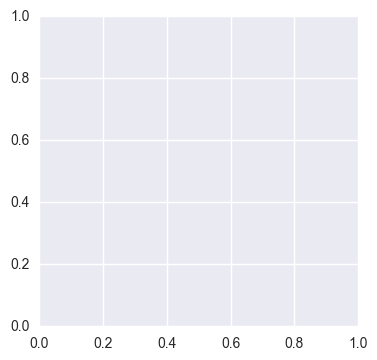

In [67]:
for j in range(1,7):
    plt.figure(figsize=(14,4))
    plt.subplot(131)
    plt.scatter(np.log10((model_table.ix[75]['model'].population_data[j]['selected']+1)/sum(model_table.ix[75]['model'].population_data[j]['selected'])),
                np.log10(model_table.ix[75,'predictions']['predictions'][j]['selection_dist']))
    plt.xlabel('data')
    plt.ylabel('model')
    plt.plot([-6,-1],[-6,-1])
    plt.subplot(132)
    plt.scatter(np.log10((model_table.ix[33]['model'].population_data[j]['selected']+1)/sum(model_table.ix[33]['model'].population_data[j]['selected'])),
                np.log10(model_table.ix[33,'predictions']['predictions'][j]['selection_dist']))
    plt.plot([-6,-1],[-6,-1])
    plt.subplot(133)
    plt.scatter(np.log10(model_table.ix[75,'predictions']['predictions'][j]['selection_dist']),
                np.log10(model_table.ix[33,'predictions']['predictions'][j]['selection_dist']))
    plt.plot([-6,-1],[-6,-1])
    plt.xlabel('model/no min rate')
    plt.ylabel('model/with min rate')
    plt.suptitle(j)